# Stock Market Analysis

#### Import required Libraries

In [27]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

import yfinance as yf

### 1. Load dataset

#### Import BRITINNIA stock

In [2]:
def extract_daily_stock_prices(symbol, filename):
    # Download stock data
    stock_data = yf.download(symbol, start="1900-01-01", )
    
    # Resample data to daily frequency
    monthly_data = stock_data.resample('D').last()
    
    try:
        # Save to CSV
        monthly_data.to_csv(filename)
        print("Data extraction and saving completed successfully.")
    
    except Exception as e:  # Catching any exceptions
        print(f"An error occurred: {str(e)}")  # Printing error message

In [3]:
symbol = 'BRITANNIA.NS'  # Adjust the symbol as per your requirement

# Define the filename for the CSV
filename = 'britannia_daily_prices.csv'

# Extract and save daily stock prices
extract_daily_stock_prices(symbol, filename)

[*********************100%%**********************]  1 of 1 completed

Data extraction and saving completed successfully.


In [4]:
# Read the CSV file into a DataFrame
data = pd.read_csv('britannia_daily_prices.csv')

In [5]:
data.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
10301,2024-03-16,NaN,NaN,NaN,NaN,NaN,NaN
10302,2024-03-17,NaN,NaN,NaN,NaN,NaN,NaN
10303,2024-03-18,4980.000000,5014.000000,4960.0,4980.000000,4980.000000,143928.0
10304,2024-03-19,4999.000000,4999.950195,4800.0,4816.950195,4816.950195,265081.0
10305,2024-03-20,4822.100098,4832.850098,4760.0,4802.899902,4802.899902,300158.0


### 2. Data cleaning and preprocessing

As per the requirement, I will work with the "Close" column only, removing the rest of the columns.

In [6]:
columns_to_keep = ['Date', 'Close']
data = data[columns_to_keep]

In [7]:
# set the frequency of the DatetimeIndex
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Close
Date,
1996-01-02,10.600000
1996-01-03,10.466666
1996-01-04,10.466666
1996-01-05,10.473333
1996-01-06,NaN


In [8]:
# summary statistics
data.describe().style.background_gradient(cmap='Pastel2')

,Close
count,7091.000000
mean,1030.735074
std,1446.920634
min,9.466666
25%,66.535000
50%,166.705002
75%,1656.274963
max,5361.299805


**Removing Null values.**

There are missing values in the data.
The shape of the dataset is:  (10306, 1)


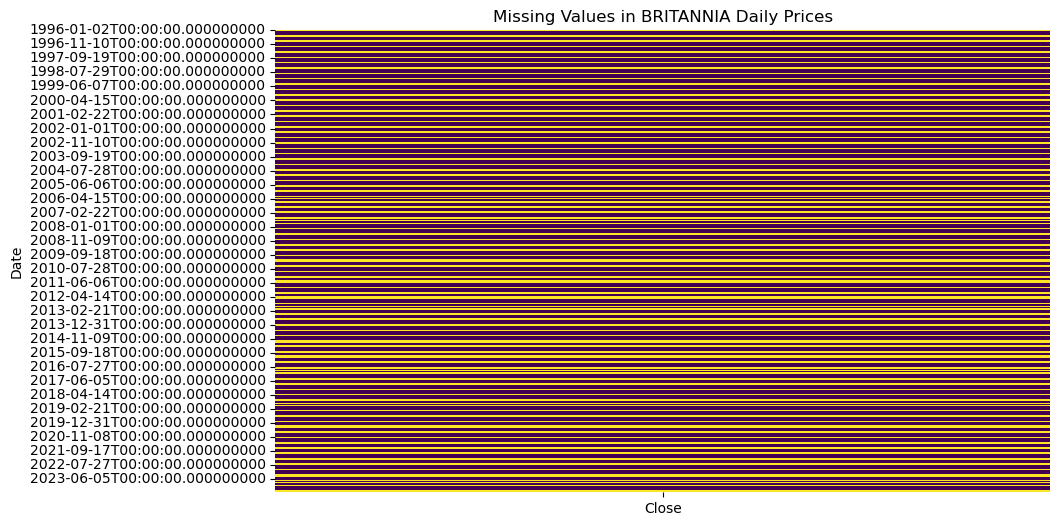

In [10]:
if data.isnull().any().any():
    print("There are missing values in the data.")
else:
    print("There are no missing values in the data.")

print("The shape of the dataset is: ", data.shape)

# Visualize missing values using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in BRITANNIA Daily Prices')
plt.show()

**Box plot to detect the outliers**

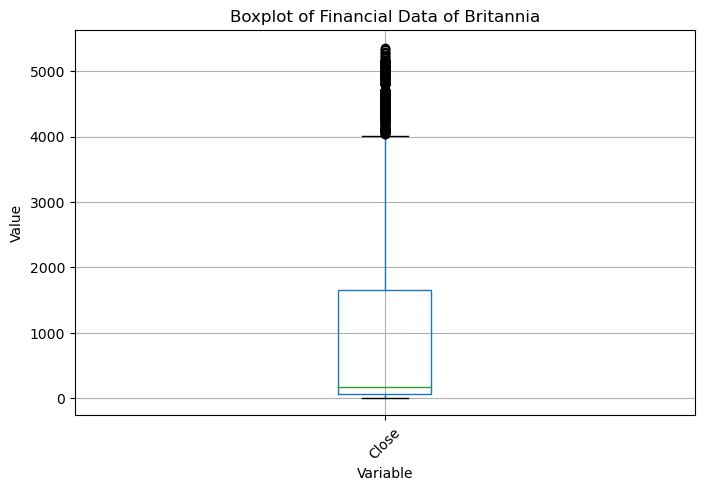

In [11]:
# Create a boxplot
plt.figure(figsize=(8, 5))
data.boxplot(column=['Close'])
plt.title('Boxplot of Financial Data of Britannia')
plt.ylabel('Value')
plt.xlabel('Variable')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Remove the outliers**

In [12]:
# Calculate the first quartile (Q1) and third quartile (Q3) of the 'Close' column
Q1 = data['Close'].quantile(0.25)
Q3 = data['Close'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the upper and lower bounds for outlier detection
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Remove outliers from the 'Close' column
data = data[(data['Close'] >= lower_bound) & (data['Close'] <= upper_bound)]

# Display the cleaned DataFrame
print(data.shape)

(6737, 1)


### 3. EDA

#### Visualize the stock’s closing price.

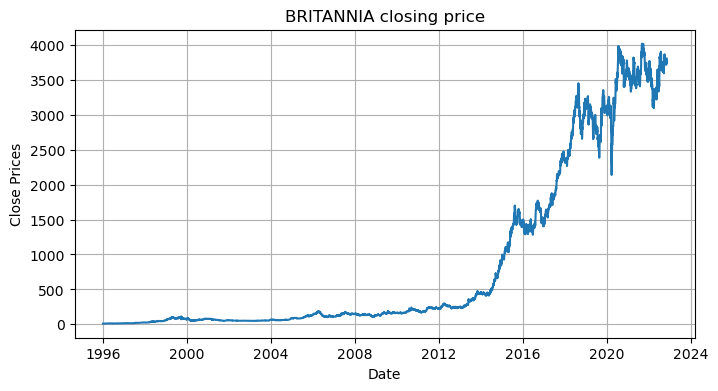

In [13]:
#plot close price
plt.figure(figsize=(8,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('BRITANNIA closing price')
plt.show()

<Axes: ylabel='Density'>

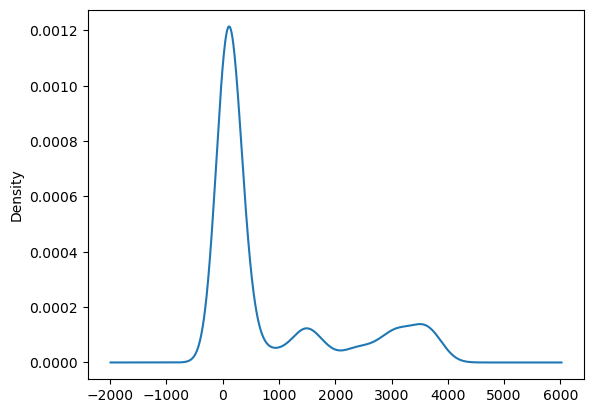

In [14]:
#Distribution of the dataset
df_close = data['Close']
df_close.plot(kind='kde')

**Visualization of Rolling Mean and Standard deviation**

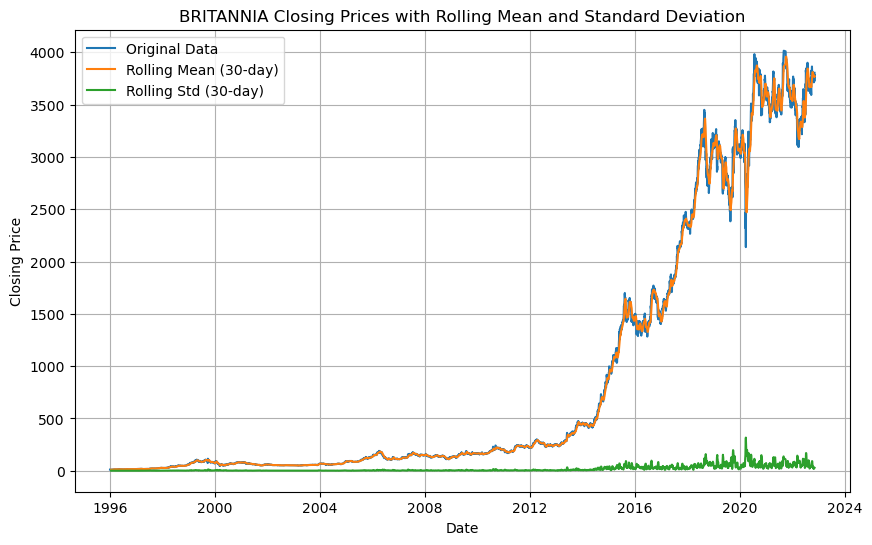

In [15]:
# Calculate and plot rolling mean and standard deviation
roll_mean = data['Close'].rolling(window=12).mean()
roll_std = data['Close'].rolling(window=12).std()

plt.figure(figsize=(10,6))
plt.plot(data['Close'], label='Original Data')
plt.plot(roll_mean, label='Rolling Mean (30-day)')
plt.plot(roll_std, label='Rolling Std (30-day)')
plt.title('BRITANNIA Closing Prices with Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

**seasonal decomposition to analyze trends and seasonality**

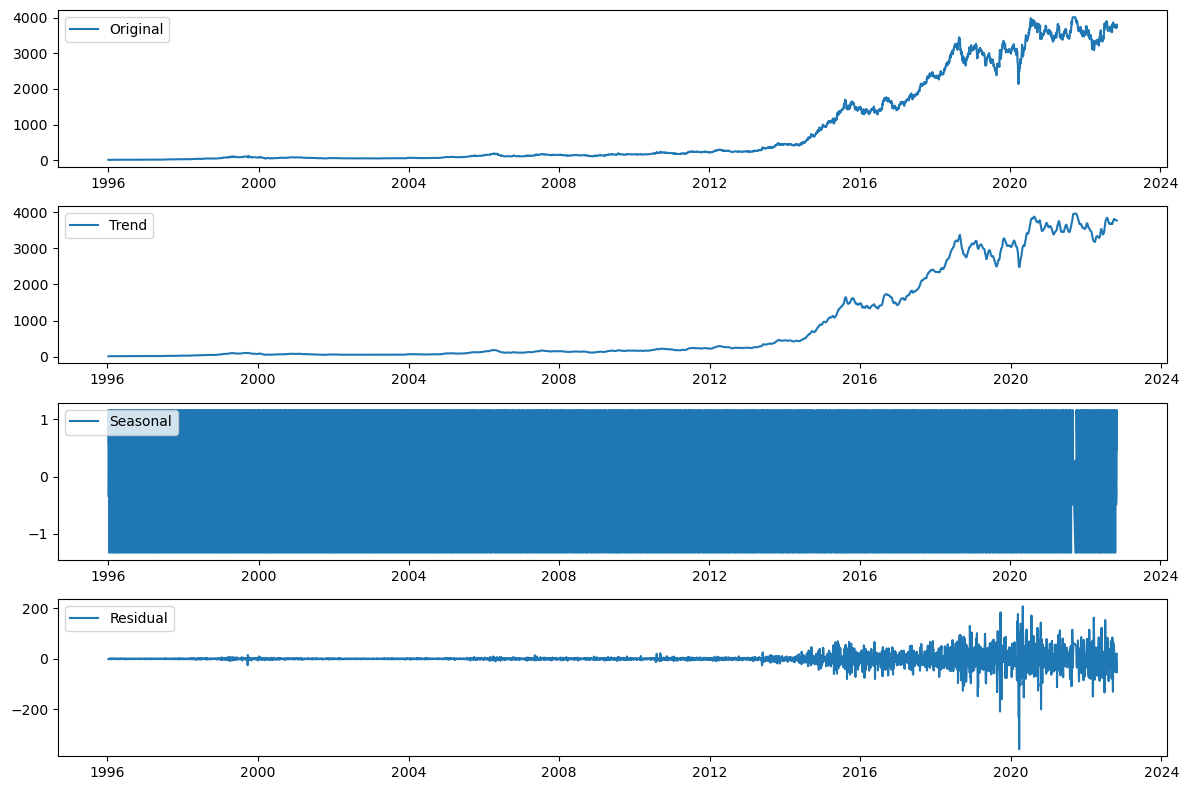

In [16]:
# Perform seasonal decomposition to analyze trends and seasonality
decomposition = seasonal_decompose(data['Close'], model='additive', period=12)

# Plot the decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data['Close'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

**check stationarity**

In [17]:
# Define a function to perform ADF test and check stationarity
def check_stationarity(timeseries):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary.")
    else:
        print("Fail to reject the null hypothesis. Data is non-stationary.")

In [18]:
# Check stationarity of the original series
print("Stationarity Test for Original Data:")
check_stationarity(data['Close'])

Stationarity Test for Original Data:
ADF Statistic: 1.2436324782785901
p-value: 0.9962739039289215
Critical Values:
   1%: -3.4313255151950286
   5%: -2.8619710963711977
   10%: -2.5669994689648994
Fail to reject the null hypothesis. Data is non-stationary.


**Make the data stationary**

In [19]:
# Apply differencing to make the data stationary
data['Close_diff'] = data['Close'].diff().dropna()

# Check for missing or infinite values
if data['Close_diff'].isnull().any() or np.isinf(data['Close_diff']).any():
    print("There are missing or infinite values in the differenced data.")
    # Handle missing or infinite values (e.g., remove or impute them)
    # For demonstration, let's remove the rows with missing or infinite values
    data = data.dropna(subset=['Close_diff']).replace([np.inf, -np.inf], np.nan).dropna(subset=['Close_diff'])
    print("Missing or infinite values removed.")

There are missing or infinite values in the differenced data.
Missing or infinite values removed.


In [20]:
# Check stationarity of the differenced series
print("\nStationarity Test for Differenced Data:")
check_stationarity(data['Close_diff'])


Stationarity Test for Differenced Data:
ADF Statistic: -15.398570771444229
p-value: 3.238047605180913e-28
Critical Values:
   1%: -3.4313255151950286
   5%: -2.8619710963711977
   10%: -2.5669994689648994
Reject the null hypothesis. Data is stationary.


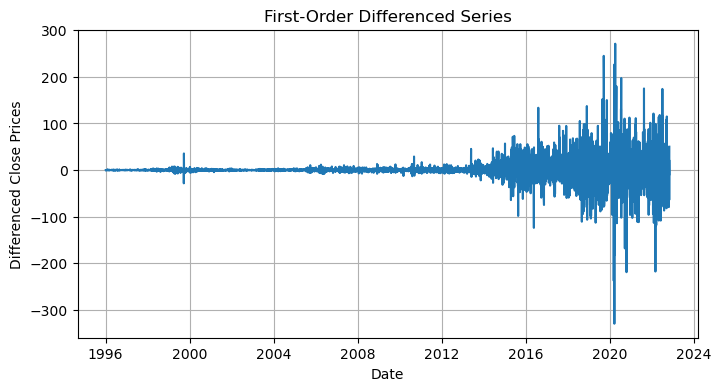

In [21]:
# Plot the differenced series
plt.figure(figsize=(8, 4))
plt.plot(data['Close_diff'])
plt.title('First-Order Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Close Prices')
plt.grid(True)
plt.show()

### 4. Model Prepaing

**Split the data**

In [23]:
# Splitting data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

#### AutoARIMA Model

In [31]:
from pmdarima import auto_arima

# Define the search criteria and fit the model
autoarima_model = auto_arima(train_data['Close_diff'], start_p=1, start_q=1, max_p=5, max_q=5, m=12, seasonal=False, trace=True)
print(autoarima_model.summary)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41926.174, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40610.221, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.97 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41924.175, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=39882.954, Time=0.74 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=39662.348, Time=0.95 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=39438.085, Time=3.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=39312.594, Time=3.43 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=18.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=14.98 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=39310.596, Time=2.20 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=39436.086, Time=1.87 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=7.59 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, 

In [34]:
# Forecast
start_index = len(train_data)
end_index = len(train_data) + len(test_data) - 1
forecast = autoarima_model.predict(n_periods=len(test_data))

In [35]:
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(test_data['Close_diff'], forecast))
print("Root Mean Squared Error (RMSE):", rmse)
mae = mean_absolute_error(test_data['Close_diff'], forecast)
print("Mean Squared Error (mae):", rmse)
r2 = r2_score(test_data['Close_diff'], forecast)
print("R-Squared Error (r2):", rmse)

Root Mean Squared Error (RMSE): 48.24969059807553
Mean Squared Error (mae): 48.24969059807553
R-Squared Error (r2): 48.24969059807553


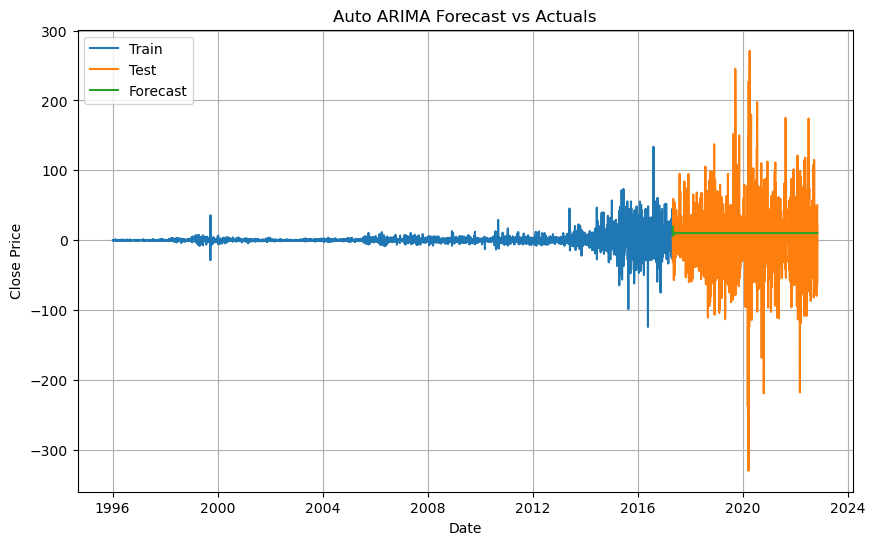

In [37]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Close_diff'], label='Train')
plt.plot(test_data.index, test_data['Close_diff'], label='Test')
plt.plot(test_data.index, forecast, label='Forecast')
plt.title('Auto ARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

#### ARIMA model

Root Mean Squared Error (RMSE): 48.24969059807553
Mean Squared Error (mae): 48.24969059807553
R-Squared Error (r2): 48.24969059807553


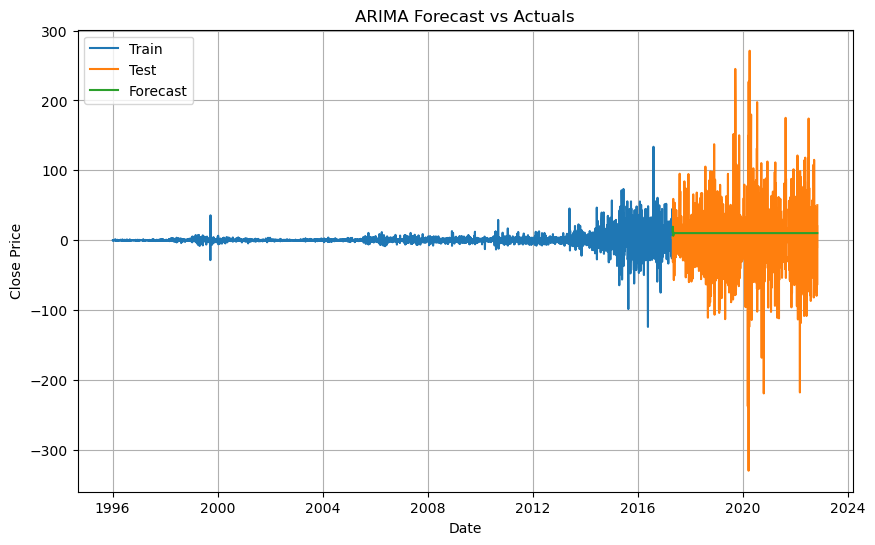

In [30]:
# Fit ARIMA model
order = (5, 1, 0)  # Define the order of the ARIMA model (p, d, q)
model = ARIMA(train_data['Close_diff'], order=order)
arima_model = model.fit()

# Forecast
start_index = len(train_data)
end_index = len(train_data) + len(test_data) - 1
forecast = arima_model.predict(start=start_index, end=end_index, typ='levels')

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(test_data['Close_diff'], forecast))
print("Root Mean Squared Error (RMSE):", rmse)
mae = mean_absolute_error(test_data['Close_diff'], forecast)
print("Mean Squared Error (mae):", rmse)
r2 = r2_score(test_data['Close_diff'], forecast)
print("R-Squared Error (r2):", rmse)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Close_diff'], label='Train')
plt.plot(test_data.index, test_data['Close_diff'], label='Test')
plt.plot(test_data.index, forecast, label='Forecast')
plt.title('ARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

#### SARIMA Model

In [43]:
# SARIMA Model
def fit_sarima(train, order, seasonal_order):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit()
    return fitted_model

def forecast_sarima(model, steps):
    forecast = model.forecast(steps=steps)
    return forecast

In [45]:
# Evaluate SARIMA model
sarima_order = (5,1,0)  # Example order, tune as needed
sarima_seasonal_order = (1, 1, 1, 12)  # Example seasonal order, tune as needed
sarima_model = fit_sarima(train_data['Close_diff'], order=sarima_order, seasonal_order=sarima_seasonal_order)
sarima_forecast = forecast_sarima(sarima_model, len(test_data))
sarima_rmse = np.sqrt(mean_squared_error(test_data['Close_diff'], sarima_forecast))
print("SARIMA RMSE:", sarima_rmse)
mae = mean_absolute_error(test_data['Close_diff'], sarima_forecast)
print("Mean Squared Error (mae):", rmse)
r2 = r2_score(test_data['Close_diff'], sarima_forecast)
print("R-Squared Error (r2):", rmse)

SARIMA RMSE: 48.511477310636295
Mean Squared Error (mae): 48.24969059807553
R-Squared Error (r2): 48.24969059807553


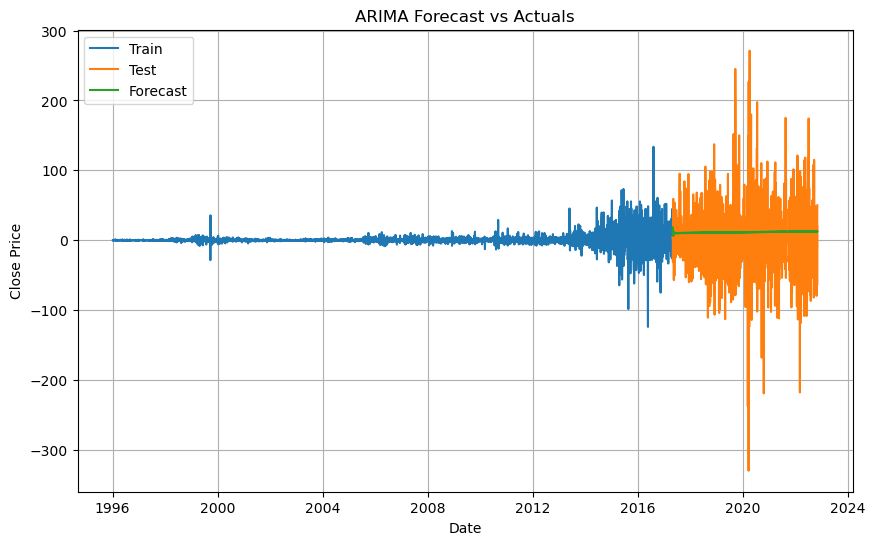

In [47]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Close_diff'], label='Train')
plt.plot(test_data.index, test_data['Close_diff'], label='Test')
plt.plot(test_data.index, sarima_forecast, label='Forecast')
plt.title('ARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

#### LSTM Model

In [50]:
# LSTM Model

def prepare_data_for_lstm(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))  # Transform Series to numpy array
    return scaled_data, scaler

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def fit_lstm(train):
    X, y = train[:-1], train[1:]
    X = X.reshape(X.shape[0], 1, 1)
    model = create_lstm_model()
    model.fit(X, y, epochs=100, batch_size=1, verbose=0)
    return model

def forecast_lstm(model, data, scaler, steps):
    forecast = []
    x_input = data[-1]
    for _ in range(steps):
        x_input = x_input.reshape((1, 1, 1))
        yhat = model.predict(x_input, verbose=0)
        forecast.append(yhat[0][0])
        x_input = np.array([yhat[0]])
    forecast = np.array(forecast)
    forecast = scaler.inverse_transform(forecast.reshape(-1, 1))
    return forecast

In [51]:
scaled_train_data, scaler = prepare_data_for_lstm(train_data['Close_diff'])  # Remove .values here
lstm_model = fit_lstm(scaled_train_data)
lstm_forecast = forecast_lstm(lstm_model, scaled_train_data, scaler, len(test_data))
lstm_forecast = lstm_forecast.flatten()  # Flatten the forecasted data
lstm_rmse = np.sqrt(mean_squared_error(test_data['Close_diff'], lstm_forecast))
print("LSTM RMSE:", lstm_rmse)

LSTM RMSE: 47.46524663960779


In [52]:
mae = mean_absolute_error(test_data['Close_diff'], lstm_forecast)
print("Mean Squared Error (mae):", rmse)
r2 = r2_score(test_data['Close_diff'], lstm_forecast)
print("R-Squared Error (r2):", rmse)

Mean Squared Error (mae): 48.24969059807553
R-Squared Error (r2): 48.24969059807553


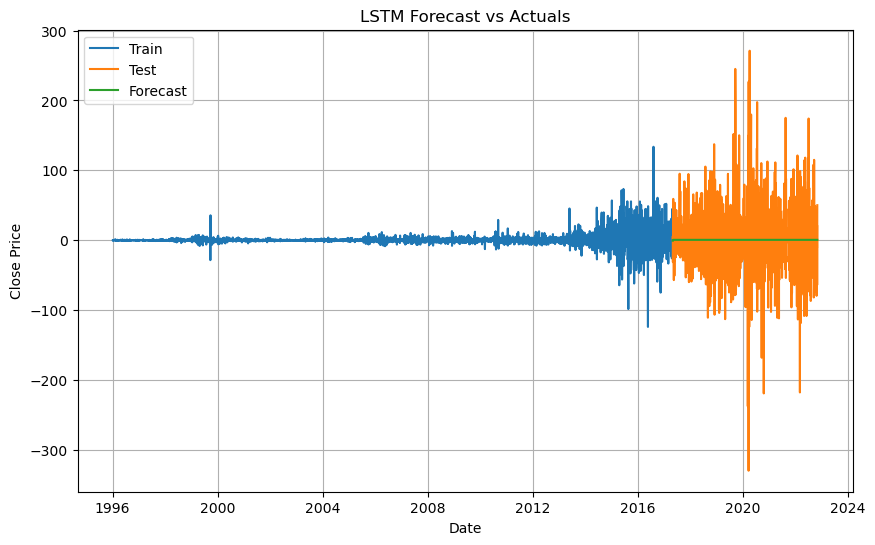

In [53]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Close_diff'], label='Train')
plt.plot(test_data.index, test_data['Close_diff'], label='Test')
plt.plot(test_data.index, lstm_forecast, label='Forecast')
plt.title('LSTM Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

As per my model report, LSTM has the lowest MEA score, i.e., 47.46, so I will prefer to use the LSTM model.